<a href="https://colab.research.google.com/github/eip4-mars/EIP4P2/blob/master/Session4/Face_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/timesler/facenet-pytorch.git
!cp -r facenet-pytorch/* .
!rm -rf facenet-pytorch

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1188 (delta 19), reused 10 (delta 2), pack-reused 1143
Receiving objects: 100% (1188/1188), 22.80 MiB | 8.65 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [ ]:
pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 48kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
## !zip crop_out.zip crop_out/*

In [ ]:
## ! pip install tensorflow==1.13.0rc1
## ! pip install scipy==1.1.0

In [ ]:
use_cuda= torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
device

device(type='cuda')

In [ ]:
!unzip /content/gdrive/My\ Drive/aligned.zip

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ColorJitter(0.2,0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/aligned/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=64, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['AB_de_Villiers',
 'MS_Dhoni',
 'Sara_Ali_Khan',
 'benedict_cumberbatch',
 'dale_steyn',
 'dominic_thiem',
 'millie_bobby_brown',
 'nick_kyrios',
 'smriti_mandhana',
 'tom_holland']

['AB_de_Villiers',
 'MS_Dhoni',
 'Sara_Ali_Khan',
 'benedict_cumberbatch',
 'dale_steyn',
 'dominic_thiem',
 'millie_bobby_brown',
 'nick_kyrios',
 'smriti_mandhana',
 'tom_holland']

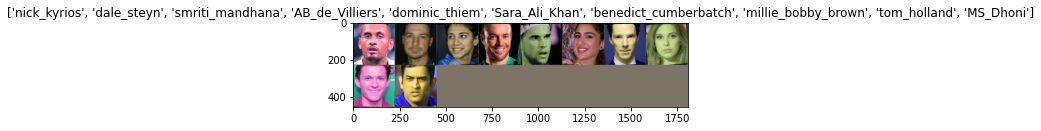

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [ ]:
use_cuda= torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')

from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

layer_list = list(model_ft.children())[-5:] # all final layers

model_ft = nn.Sequential(*list(model_ft.children())[:-5])
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(1)
model_ft.flatten_last = Flatten()
model_ft.dropout = nn.Dropout(p=0.5)
model_ft.last_linear = nn.Linear(1792, 512, bias=False)
model_ft.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
model_ft.logits = nn.Linear(512, len(class_names))
model_ft = model_ft.to(device)

Running on device: cuda


In [ ]:
from torchsummary import summary
model_ft.to(device)
summary(model_ft, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [ ]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.5, patience=5, verbose=False, threshold=0.01, threshold_mode='rel', cooldown=0)

In [ ]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('LR : ',optimizer.param_groups[0]['lr'])
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            if phase == 'train':
                scheduler.step(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/499
LR :  0.1
----------
train Loss: 2.7882 Acc: 0.0000
val Loss: 1.8341 Acc: 1.0000
Epoch 1/499
LR :  0.1
----------
train Loss: 0.0083 Acc: 1.0000
val Loss: 1.2490 Acc: 1.0000
Epoch 2/499
LR :  0.1
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.7564 Acc: 1.0000
Epoch 3/499
LR :  0.1
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.4153 Acc: 1.0000
Epoch 4/499
LR :  0.1
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.2227 Acc: 1.0000
Epoch 5/499
LR :  0.1
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.1204 Acc: 1.0000
Epoch 6/499
LR :  0.1
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0653 Acc: 1.0000
Epoch 7/499
LR :  0.1
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0343 Acc: 1.0000
Epoch 8/499
LR :  0.05
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.0223 Acc: 1.0000
Epoch 9/499
LR :  0.05
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0151 Acc: 1.0000
Epoch 10/499
LR :  0.05
----------
train Loss: 0.0000 Acc: 1.0000
va

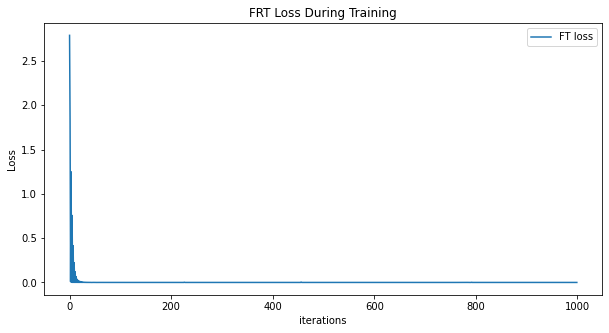

In [ ]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=500)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import files
model_ft.to(torch.device('cpu'))
model_ft.eval()
traced_model = torch.jit.trace(model_ft,torch.randn(1,3,244,244))
traced_model.save("inception_fr.pt")
files.download("inception_fr.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>